In [23]:
# Core
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# Request the description of each col
from projeto1bi.utils import dic_cols

# Viz (quick EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: data prep, CV, metrics, baseline models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Quality of life
import warnings; warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

In [24]:
data_path = r"C:\Users\rapha\OneDrive\Documents\Data Science\PADSD\3o Tri\Pratica Avancada de Data Science e Visualizacao\projeto1bi\data"

dim_teachers    = pd.read_csv(f"{data_path}\\dim_teachers.csv")
fct_interaction = pd.read_csv(f"{data_path}\\fct_teachers_contents_interactions.csv")
fct_entries     = pd.read_csv(f"{data_path}\\fct_teachers_entries.csv")
dictionary      = pd.read_csv(f"{data_path}\\aprendizap_dictionary.csv")

In [25]:
fct_entries["data_inicio"] = pd.to_datetime(fct_entries["data_inicio"], errors="coerce")
fct_entries["data_fim"] = pd.to_datetime(fct_entries["data_fim"], errors="coerce")
fct_interaction["data_inicio"] = pd.to_datetime(fct_interaction["data_inicio"], errors="coerce")

fct_entries["tempo_sessao"] = fct_entries["data_fim"] - fct_entries["data_inicio"]
fct_entries["tempo_sessao"] = fct_entries["tempo_sessao"].dt.total_seconds() / 60

In [26]:
fct_interaction.head()

,unique_id,user_type,user_agent_device_type,data_inicio,event_type,content_type,id_aula,utm_source
0,599e78c8-a3ed-4a43-bf99-9ceb012079e4,registered,NaN,2024-05-19 18:26:22.525,criacao_turma_relatorio,relatorio,NaN,NaN
1,794850fa-e0a3-4bdb-821a-32fb8657e981,registered,NaN,2024-02-07 22:37:41.864,criacao_anotacao_relatorio,relatorio,NaN,NaN
2,b507b6b4-21c3-4f93-9126-7341040579aa,registered,NaN,2024-03-27 06:53:24.246,criacao_anotacao_relatorio,relatorio,NaN,NaN
3,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-01 17:23:51.336,criacao_anotacao_relatorio,relatorio,NaN,NaN
4,707c5747-f213-402f-896b-f8129fe36910,registered,NaN,2024-04-02 11:41:33.447,criacao_anotacao_relatorio,relatorio,NaN,NaN


In [27]:
fct_entries.head()

,unique_id,user_type,data_inicio,data_fim,tempo_sessao
0,648c29c1-5c68-4308-bc40-f85a4ab760f8,seo,2022-12-12 15:35:03.601,2022-12-12 15:35:36.305,0.545067
1,463135f9-2345-4b25-845f-bc52f6e41362,seo,2023-04-11 08:55:55.225,2023-04-11 08:56:56.637,1.023533
2,0bb96cab-5bd6-4e80-beff-9bb58590b0cb,seo,2023-03-30 12:27:39.857,2023-03-30 12:27:40.077,0.003667
3,6d38f15b-a76d-4b92-bddb-1d6e4ec4deec,seo,2023-06-06 22:20:14.298,2023-06-06 22:20:14.629,0.005517
4,4c3edd9b-2f40-491f-9e88-5e8bf90accbb,seo,2023-05-29 19:26:15.913,2023-05-29 19:26:16.139,0.003767


In [28]:
import pandas as pd

# Documentação:
# O objetivo é criar duas novas colunas no dataframe 'fct_entries'
# a partir da coluna de timestamp 'data_inicio'.

# --- 1. EXTRAINDO O DIA DA SEMANA ---

# Criamos um mapa para traduzir o número do dia da semana (onde Segunda=0, Domingo=6)
# para as abreviações em português que você pediu.
mapa_dia_semana = {
    0: 'seg',
    1: 'ter',
    2: 'qua',
    3: 'qui',
    4: 'sex',
    5: 'sab',
    6: 'dom'
}

# Usamos o acessor .dt.weekday para obter o número do dia e .map() para aplicar nossa tradução.
fct_entries['dia_semana'] = fct_entries['data_inicio'].dt.weekday.map(mapa_dia_semana)
print("Coluna 'dia_semana' criada com sucesso.")


# --- 2. EXTRAINDO O PERÍODO DO DIA ---

# Definimos os limites e os nomes para cada período do dia.
# Madrugada: 0h-5h | Manhã: 6h-11h | Tarde: 12h-17h | Noite: 18h-23h
bins = [-1, 5, 11, 17, 23]
labels = ['madrugada', 'manha', 'tarde', 'noite']

# Usamos o acessor .dt.hour para extrair a hora e a função pd.cut para categorizar em períodos.
# pd.cut é uma forma muito eficiente de criar categorias a partir de valores numéricos.
fct_entries['periodo_dia'] = pd.cut(fct_entries['data_inicio'].dt.hour, bins=bins, labels=labels, right=True)
print("Coluna 'periodo_dia' criada com sucesso.")


# --- 3. VERIFICAÇÃO ---
# Mostramos as 5 primeiras linhas com as novas colunas para verificação.
print("\n--- Amostra do resultado ---")
print(fct_entries[['data_inicio', 'dia_semana', 'periodo_dia']].head())

# Mostramos a contagem de entradas por período para análise.
print("\n--- Distribuição por Período do Dia ---")
print(fct_entries['periodo_dia'].value_counts())

print("\n--- Distribuição por Dia da Semana ---")
print(fct_entries['dia_semana'].value_counts())

Coluna 'dia_semana' criada com sucesso.
Coluna 'periodo_dia' criada com sucesso.

--- Amostra do resultado ---
              data_inicio dia_semana periodo_dia
0 2022-12-12 15:35:03.601        seg       tarde
1 2023-04-11 08:55:55.225        ter       manha
2 2023-03-30 12:27:39.857        qui       tarde
3 2023-06-06 22:20:14.298        ter       noite
4 2023-05-29 19:26:15.913        seg       noite

--- Distribuição por Período do Dia ---
periodo_dia
tarde        919640
manha        852538
noite        565956
madrugada    107916
Name: count, dtype: int64

--- Distribuição por Dia da Semana ---
dia_semana
seg    462201
ter    411911
qua    401060
qui    380485
sex    297310
dom    294373
sab    198710
Name: count, dtype: int64


In [29]:
elementos = [fct_interaction['event_type'].unique(),fct_interaction['content_type'].unique(),fct_interaction['id_aula'].unique(),fct_interaction['utm_source'].unique()]

for elemento in elementos:
    print
    print(elemento)

['criacao_turma_relatorio' 'criacao_anotacao_relatorio'
 'visualizacao_aula' 'visualizacao_metodologia_ativa' 'download_aula' nan
 'compartilhamento_direto' 'visualizacao_avaliacao'
 'botao_criar_plano_aula' 'download_avaliacao' 'visualizacao_conteudo_ia'
 'download_plano_aula' 'visualizacao_prova' 'visualizacao_plano_aula'
 'criacao_plano_aula' 'envio_email_ou_baixou_prova' 'rascunho_plano_aula'
 'botao_criar_plano_sem_aula' 'download_conteudo_ia'
 'fechar_conquista_obtida' 'rascunho_prova' 'prova_salva'
 'acesso_aba_conquistas' 'acesso_comunidade' 'click_subaba_disponiveis'
 'click_subaba_concluidas' 'click_link_missao_aulas'
 'click_link_missao_relatorio_turma' 'botao_baixar_conquista_modal'
 'botao_compartilhar_conquista_modal' 'click_selo_conquista'
 'botao_baixar_conquista_completada' 'click_link_missao_plano_de_aula'
 'botao_compartilhar_conquista_completada' 'click_link_missao_mari'
 'click_link_missao_blog' 'click_link_missao_comunidade']
['relatorio' nan 'pagina_metodologia_a

In [30]:
import pandas as pd

# Documentação:
# O objetivo é criar um dataframe que, para cada par (unique_id, dia) presente em fct_entries,
# mostre o número total de interações daquele unique_id naquele dia, contado a partir de fct_interaction.

# --- 1. PREPARAÇÃO DOS DATAFRAMES ---

# Garantir que as colunas de data em ambas as tabelas estão no formato datetime
print("Preparando as colunas de data...")
fct_entries['data_inicio'] = pd.to_datetime(fct_entries['data_inicio'])
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])

# Extrair a data (sem a hora) em ambas as tabelas para criar uma chave comum
fct_entries['data'] = fct_entries['data_inicio'].dt.date
fct_interaction['data'] = fct_interaction['data_inicio'].dt.date
print("Colunas 'data' criadas com sucesso.")


# --- 2. CRIAR A BASE DE "PROFESSOR-DIA" A PARTIR DE FCT_ENTRIES ---

# Selecionamos os pares únicos de (unique_id, data) de fct_entries.
# Esta é a nossa lista de "dias ativos" para cada professor.
print("\nIdentificando dias com sessões ativas por professor...")
dias_com_sessao = fct_entries[['unique_id', 'data']].drop_duplicates().reset_index(drop=True)
print(f"Encontrados {len(dias_com_sessao)} pares únicos de 'professor-dia' em fct_entries.")


# --- 3. CALCULAR CONTAGEM DE INTERAÇÕES A PARTIR DE FCT_INTERACTION ---

# Calculamos o número de interações por professor e por dia.
print("\nCalculando o número de interações por dia em fct_interaction...")
contagem_interacoes = fct_interaction.groupby(['unique_id', 'data']).size().reset_index(name='numero_interacoes')
print("Contagem de interações concluída.")


# --- 4. UNIFICAR OS RESULTADOS ---

# Unimos nossa base de 'dias_com_sessao' com a 'contagem_interacoes'.
# Usamos um 'left merge' para garantir que manteremos todos os dias em que houve sessão.
print("\nUnificando os resultados...")
resultado_final = pd.merge(
    dias_com_sessao,
    contagem_interacoes,
    on=['unique_id', 'data'],
    how='left'
)

# Se um dia teve sessão mas nenhuma interação, o resultado do merge será NaN.
# Preenchemos esses casos com 0, pois significa 0 interações.
resultado_final['numero_interacoes'].fillna(0, inplace=True)
resultado_final['numero_interacoes'] = resultado_final['numero_interacoes'].astype(int)
print("Unificação e limpeza concluídas.")


# --- 5. VERIFICAÇÃO ---
print("\n--- Amostra do Resultado Final ---")
print(resultado_final.head(10))
print(f"\nO dataframe final 'resultado_final' foi criado com {resultado_final.shape[0]} linhas.")

Preparando as colunas de data...
Colunas 'data' criadas com sucesso.

Identificando dias com sessões ativas por professor...
Encontrados 1874162 pares únicos de 'professor-dia' em fct_entries.

Calculando o número de interações por dia em fct_interaction...
Contagem de interações concluída.

Unificando os resultados...
Unificação e limpeza concluídas.

--- Amostra do Resultado Final ---
                              unique_id        data  numero_interacoes
0  648c29c1-5c68-4308-bc40-f85a4ab760f8  2022-12-12                  1
1  463135f9-2345-4b25-845f-bc52f6e41362  2023-04-11                  5
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb  2023-03-30                  1
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec  2023-06-06                  1
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb  2023-05-29                  1
5  8e6f9ebc-41b4-4bf6-9fda-a3716d30a34d  2023-05-15                  0
6  d87c6e65-8f5a-48b1-905c-1a6dbf454532  2023-07-04                  1
7  e84c023b-df1e-48e0-9016-22d04cd0d5ab  2

In [31]:
# Documentação:
# O objetivo é unificar o dataframe 'fct_entries' com o 'resultado_final'.
# Isso irá adicionar a coluna 'numero_interacoes' a cada linha de 'fct_entries',
# com base na correspondência de 'unique_id' e 'data'.

print("Iniciando a unificação de 'fct_entries' com 'resultado_final'...")

# Usamos um 'left merge' para garantir que todas as linhas (sessões) de fct_entries sejam mantidas.
# A chave da unificação são as colunas 'unique_id' e 'data'.
df_unificado_final = pd.merge(
    fct_entries,
    resultado_final,
    on=['unique_id', 'data'],
    how='left'
)

# O merge deve ser limpo, mas por segurança, vamos verificar se algum NaN foi criado.
# Isso poderia acontecer se, por alguma razão, um par (unique_id, data) em fct_entries
# não estivesse em resultado_final. Preenchemos com 0.
df_unificado_final['numero_interacoes'].fillna(0, inplace=True)
df_unificado_final['numero_interacoes'] = df_unificado_final['numero_interacoes'].astype(int)


print("Unificação concluída com sucesso.")


# --- VERIFICAÇÃO ---
# Mostramos o resultado, selecionando colunas chave para confirmar que a unificação funcionou.
print("\n--- Amostra do DataFrame Unificado Final ---")
colunas_para_verificar = [
    'unique_id',
    'data_inicio',      # A data/hora original da sessão
    'tempo_sessao',       # O tempo da sessão específica
    'data',             # A data que usamos como chave
    'numero_interacoes' # O número total de interações naquele dia
]
print(df_unificado_final[colunas_para_verificar].head())

print(f"\nO dataframe final 'df_unificado_final' tem {df_unificado_final.shape[0]} linhas.")

Iniciando a unificação de 'fct_entries' com 'resultado_final'...
Unificação concluída com sucesso.

--- Amostra do DataFrame Unificado Final ---
                              unique_id             data_inicio  tempo_sessao  \
0  648c29c1-5c68-4308-bc40-f85a4ab760f8 2022-12-12 15:35:03.601      0.545067   
1  463135f9-2345-4b25-845f-bc52f6e41362 2023-04-11 08:55:55.225      1.023533   
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb 2023-03-30 12:27:39.857      0.003667   
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec 2023-06-06 22:20:14.298      0.005517   
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb 2023-05-29 19:26:15.913      0.003767   

         data  numero_interacoes  
0  2022-12-12                  1  
1  2023-04-11                  5  
2  2023-03-30                  1  
3  2023-06-06                  1  
4  2023-05-29                  1  

O dataframe final 'df_unificado_final' tem 2446050 linhas.


In [32]:
# Documentação:
# O objetivo é criar duas novas colunas, 'ano' e 'mes',
# a partir da coluna 'data_inicio' do dataframe 'df_unificado_final'.

print("Adicionando colunas de ano e mês...")

# --- 1. PREPARAÇÃO (SEGURANÇA) ---
# Garantimos que a coluna 'data_inicio' está no formato datetime.
df_unificado_final['data_inicio'] = pd.to_datetime(df_unificado_final['data_inicio'])


# --- 2. CRIAÇÃO DAS COLUNAS ---
# Usamos o acessor .dt para extrair o ano (.dt.year) e o mês (.dt.month).
df_unificado_final['ano'] = df_unificado_final['data_inicio'].dt.year
df_unificado_final['mes'] = df_unificado_final['data_inicio'].dt.month

print("Colunas 'ano' e 'mes' criadas com sucesso.")


# --- 3. VERIFICAÇÃO ---
# Mostramos as 5 primeiras linhas com a data original e as novas colunas para verificação.
print("\n--- Amostra do resultado ---")
print(df_unificado_final[['data_inicio', 'ano', 'mes']].head())

# Mostramos a contagem de entradas por ano e mês para uma análise rápida.
print("\n--- Distribuição por Ano ---")
print(df_unificado_final['ano'].value_counts().sort_index())

print("\n--- Distribuição por Mês ---")
print(df_unificado_final['mes'].value_counts().sort_index())

Adicionando colunas de ano e mês...
Colunas 'ano' e 'mes' criadas com sucesso.

--- Amostra do resultado ---
              data_inicio   ano  mes
0 2022-12-12 15:35:03.601  2022   12
1 2023-04-11 08:55:55.225  2023    4
2 2023-03-30 12:27:39.857  2023    3
3 2023-06-06 22:20:14.298  2023    6
4 2023-05-29 19:26:15.913  2023    5

--- Distribuição por Ano ---
ano
2022    385666
2023    822884
2024    945757
2025    291743
Name: count, dtype: int64

--- Distribuição por Mês ---
mes
1      83533
2     191292
3     278693
4     260688
5     246063
6     235355
7     192038
8     247777
9     224490
10    202013
11    193131
12     90977
Name: count, dtype: int64


In [33]:
# Documentação:
# Versão otimizada para memória do código de unificação.
# O processo é feito em etapas para evitar a criação de dataframes intermediários grandes.

# --- 1. PREPARAÇÃO ---
print("Preparando as colunas de data...")
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])
fct_interaction['data'] = fct_interaction['data_inicio'].dt.date
resultado_final['data'] = pd.to_datetime(resultado_final['data']).dt.date
print("Colunas de data verificadas.")

# Começamos com uma cópia do 'resultado_final' que será nosso dataframe final
df_resultado_final_enriquecido = resultado_final.copy()


# --- 2. PIVOTAR E UNIR 'event_type' ---
print("\nProcessando 'event_type'...")
agg_event_diario = fct_interaction.groupby(['unique_id', 'data', 'event_type']).size().unstack(fill_value=0).add_prefix('evento_')

# Unimos a primeira parte
df_resultado_final_enriquecido = pd.merge(df_resultado_final_enriquecido, agg_event_diario, on=['unique_id', 'data'], how='left')

# Otimizamos os tipos de dados das novas colunas
colunas_evento = [col for col in df_resultado_final_enriquecido.columns if col.startswith('evento_')]
df_resultado_final_enriquecido[colunas_evento] = df_resultado_final_enriquecido[colunas_evento].fillna(0).apply(pd.to_numeric, downcast='integer')


# --- 3. PIVOTAR E UNIR 'content_type' ---
print("Processando 'content_type'...")
agg_content_diario = fct_interaction.groupby(['unique_id', 'data', 'content_type']).size().unstack(fill_value=0).add_prefix('conteudo_')

# Unimos a segunda parte
df_resultado_final_enriquecido = pd.merge(df_resultado_final_enriquecido, agg_content_diario, on=['unique_id', 'data'], how='left')

# Otimizamos os tipos de dados
colunas_conteudo = [col for col in df_resultado_final_enriquecido.columns if col.startswith('conteudo_')]
df_resultado_final_enriquecido[colunas_conteudo] = df_resultado_final_enriquecido[colunas_conteudo].fillna(0).apply(pd.to_numeric, downcast='integer')


# --- 4. PIVOTAR E UNIR 'user_type' ---
print("Processando 'user_type'...")
agg_user_diario = fct_interaction.groupby(['unique_id', 'data', 'user_type']).size().unstack(fill_value=0).add_prefix('usertype_')

# Unimos a última parte
df_resultado_final_enriquecido = pd.merge(df_resultado_final_enriquecido, agg_user_diario, on=['unique_id', 'data'], how='left')

# Otimizamos os tipos de dados
colunas_usertype = [col for col in df_resultado_final_enriquecido.columns if col.startswith('usertype_')]
df_resultado_final_enriquecido[colunas_usertype] = df_resultado_final_enriquecido[colunas_usertype].fillna(0).apply(pd.to_numeric, downcast='integer')

print("\nUnificação otimizada concluída com sucesso.")


# --- 5. VERIFICAÇÃO ---
print("\n--- Amostra do DataFrame Final Enriquecido ---")
print(df_resultado_final_enriquecido.head())

print(f"\nO dataframe final 'df_resultado_final_enriquecido' foi criado com {df_resultado_final_enriquecido.shape[0]} linhas e {df_resultado_final_enriquecido.shape[1]} colunas.")

# Checamos o uso de memória para ver o impacto da otimização
df_resultado_final_enriquecido.info(memory_usage='deep')

Preparando as colunas de data...
Colunas de data verificadas.

Processando 'event_type'...
Processando 'content_type'...
Processando 'user_type'...

Unificação otimizada concluída com sucesso.

--- Amostra do DataFrame Final Enriquecido ---
                              unique_id        data  numero_interacoes  \
0  648c29c1-5c68-4308-bc40-f85a4ab760f8  2022-12-12                  1   
1  463135f9-2345-4b25-845f-bc52f6e41362  2023-04-11                  5   
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb  2023-03-30                  1   
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec  2023-06-06                  1   
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb  2023-05-29                  1   

   evento_acesso_aba_conquistas  evento_acesso_comunidade  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4        

In [34]:
import pandas as pd
import gc # Importamos o Garbage Collector

# Documentação:
# Versão ultra otimizada para memória. Otimizamos os tipos de dados ANTES de cada merge
# e limpamos a memória após cada etapa.

# --- 1. PREPARAÇÃO ---
print("Iniciando a preparação dos dataframes...")
df_final_completo = df_unificado_final.copy()
fct_interaction['data_inicio'] = pd.to_datetime(fct_interaction['data_inicio'])
fct_interaction['data'] = fct_interaction['data_inicio'].dt.date
print("Dataframes prontos.")


# --- 2. PIVOTAR, OTIMIZAR E UNIR 'event_type' ---
print("\nProcessando 'event_type'...")
agg_event_diario = fct_interaction.groupby(['unique_id', 'data', 'event_type']).size().unstack(fill_value=0).add_prefix('evento_')

# OTIMIZAÇÃO: Reduz o tamanho do dataframe pivotado ANTES do merge
colunas_evento = agg_event_diario.columns
agg_event_diario[colunas_evento] = agg_event_diario[colunas_evento].apply(pd.to_numeric, downcast='integer')
print(f"Tipos de dados de 'agg_event_diario' otimizados. Uso de memória: {agg_event_diario.memory_usage(deep=True).sum() / 1e6:.2f} MB")

df_final_completo = pd.merge(df_final_completo, agg_event_diario, on=['unique_id', 'data'], how='left')
df_final_completo[colunas_evento] = df_final_completo[colunas_evento].fillna(0).apply(pd.to_numeric, downcast='integer')

# Limpamos a memória
del agg_event_diario
gc.collect()


# --- 3. PIVOTAR, OTIMIZAR E UNIR 'content_type' ---
print("\nProcessando 'content_type'...")
agg_content_diario = fct_interaction.groupby(['unique_id', 'data', 'content_type']).size().unstack(fill_value=0).add_prefix('conteudo_')

# OTIMIZAÇÃO
colunas_conteudo = agg_content_diario.columns
agg_content_diario[colunas_conteudo] = agg_content_diario[colunas_conteudo].apply(pd.to_numeric, downcast='integer')
print(f"Tipos de dados de 'agg_content_diario' otimizados. Uso de memória: {agg_content_diario.memory_usage(deep=True).sum() / 1e6:.2f} MB")

df_final_completo = pd.merge(df_final_completo, agg_content_diario, on=['unique_id', 'data'], how='left')
df_final_completo[colunas_conteudo] = df_final_completo[colunas_conteudo].fillna(0).apply(pd.to_numeric, downcast='integer')

# Limpamos a memória
del agg_content_diario
gc.collect()


# --- 4. PIVOTAR, OTIMIZAR E UNIR 'user_type' ---
print("\nProcessando 'user_type'...")
agg_user_diario = fct_interaction.groupby(['unique_id', 'data', 'user_type']).size().unstack(fill_value=0).add_prefix('usertype_')

# OTIMIZAÇÃO
colunas_usertype = agg_user_diario.columns
agg_user_diario[colunas_usertype] = agg_user_diario[colunas_usertype].apply(pd.to_numeric, downcast='integer')
print(f"Tipos de dados de 'agg_user_diario' otimizados. Uso de memória: {agg_user_diario.memory_usage(deep=True).sum() / 1e6:.2f} MB")

df_final_completo = pd.merge(df_final_completo, agg_user_diario, on=['unique_id', 'data'], how='left')
df_final_completo[colunas_usertype] = df_final_completo[colunas_usertype].fillna(0).apply(pd.to_numeric, downcast='integer')

# Limpamos a memória
del agg_user_diario
gc.collect()

print("\nUnificação ultra otimizada concluída com sucesso.")


# --- 5. VERIFICAÇÃO ---
print("\n--- Amostra do DataFrame Final e Completo ---")
print(df_final_completo.head())
print(f"\nO dataframe final 'df_final_completo' foi criado com {df_final_completo.shape[0]} linhas e {df_final_completo.shape[1]} colunas.")

Iniciando a preparação dos dataframes...
Dataframes prontos.

Processando 'event_type'...
Tipos de dados de 'agg_event_diario' otimizados. Uso de memória: 157.99 MB

Processando 'content_type'...
Tipos de dados de 'agg_content_diario' otimizados. Uso de memória: 11.25 MB

Processando 'user_type'...
Tipos de dados de 'agg_user_diario' otimizados. Uso de memória: 103.73 MB

Unificação ultra otimizada concluída com sucesso.

--- Amostra do DataFrame Final e Completo ---
                              unique_id user_type             data_inicio  \
0  648c29c1-5c68-4308-bc40-f85a4ab760f8       seo 2022-12-12 15:35:03.601   
1  463135f9-2345-4b25-845f-bc52f6e41362       seo 2023-04-11 08:55:55.225   
2  0bb96cab-5bd6-4e80-beff-9bb58590b0cb       seo 2023-03-30 12:27:39.857   
3  6d38f15b-a76d-4b92-bddb-1d6e4ec4deec       seo 2023-06-06 22:20:14.298   
4  4c3edd9b-2f40-491f-9e88-5e8bf90accbb       seo 2023-05-29 19:26:15.913   

                 data_fim  tempo_sessao dia_semana periodo_dia   

In [35]:
# Documentação:
# O objetivo é identificar e quantificar os dados faltantes (NaN) no dataframe 'dim_teachers'.

print("--- Análise de Dados Faltantes (NaN) em 'dim_teachers' ---")

# Calcula a contagem de NAs por coluna
dados_faltantes_cont = dim_teachers.isnull().sum()

# Calcula a porcentagem de NAs por coluna
dados_faltantes_perc = (dados_faltantes_cont / len(dim_teachers)) * 100

# Cria um novo dataframe para exibir os resultados de forma organizada
df_dados_faltantes = pd.DataFrame({
    'Contagem de NAs': dados_faltantes_cont,
    'Porcentagem de NAs (%)': dados_faltantes_perc
})

# Filtra para mostrar apenas as colunas que de fato têm dados faltantes
df_dados_faltantes = df_dados_faltantes[df_dados_faltantes['Contagem de NAs'] > 0]

# Ordena o resultado para mostrar as colunas mais críticas no topo
df_dados_faltantes = df_dados_faltantes.sort_values(by='Porcentagem de NAs (%)', ascending=False)


# Exibe o resultado final
if df_dados_faltantes.empty:
    print("\nÓtima notícia! Não há dados faltantes no dataframe 'dim_teachers'.")
else:
    print(df_dados_faltantes)

--- Análise de Dados Faltantes (NaN) em 'dim_teachers' ---
                              Contagem de NAs  Porcentagem de NAs (%)
visualizou_metodologia_ativa          1301135               98.863304
login_google                          1282226               97.426554
profid                                1250221               94.994738
selectedsubjectsem                    1247314               94.773858
estado                                1227159               93.242433
selectedsubjectsfundii                1210226               91.955824
total_alunos                          1178272               89.527884
selectedstages                        1175025               89.281169
currentsubject                        1163164               88.379942
currentstage                          1162904               88.360187


In [36]:
dados_faltantes_cont = dim_teachers.isnull().sum()
dados_faltantes_cont

unique_id                             0
profid                          1250221
utm_origin                            0
tela_origem                           0
estado                          1227159
total_alunos                    1178272
login_google                    1282226
currentstage                    1162904
currentsubject                  1163164
selectedstages                  1175025
selectedsubjectsem              1247314
selectedsubjectsfundii          1210226
visualizou_metodologia_ativa    1301135
data_entrada                          0
dtype: int64

In [37]:
# Documentação:
# Este código executa duas tarefas principais:
# 1. Adiciona colunas selecionadas do 'dim_teachers' ao 'df_final_completo'.
# 2. Divide o dataframe enriquecido em múltiplos dataframes, um para cada ano.

# --- PASSO 1: INCLUINDO COLUNAS DE 'dim_teachers' ---

print("Iniciando a unificação com colunas de 'dim_teachers'...")

# Lista das colunas que queremos adicionar
colunas_para_adicionar = [
    'unique_id', # Chave para a unificação
    'estado',
    'data_entrada',
    'total_alunos',
    'currentstage',
    'currentsubject'
]

# Por segurança, selecionamos apenas as colunas que realmente existem em dim_teachers
colunas_existentes_em_dim = [col for col in colunas_para_adicionar if col in dim_teachers.columns]

# Para evitar adicionar colunas duplicadas, verificamos quais já não estão em df_final_completo (exceto a chave)
colunas_a_unir = [col for col in colunas_existentes_em_dim if col not in df_final_completo.columns or col == 'unique_id']

if len(colunas_a_unir) > 1: # Se houver mais do que apenas a chave 'unique_id'
    # Usamos um 'left merge' para adicionar as informações ao nosso dataframe principal
    df_final_completo = pd.merge(
        df_final_completo,
        dim_teachers[colunas_a_unir], # Usamos apenas o subconjunto de colunas
        on='unique_id',
        how='left'
    )
    print(f"Colunas adicionadas com sucesso: {colunas_a_unir[1:]}")
else:
    print("Nenhuma coluna nova para adicionar (provavelmente já foram incluídas).")


# --- PASSO 2: DIVIDINDO O DATAFRAME POR ANO ---

print("\nDividindo o dataframe final por ano...")

# Primeiro, garantimos que a coluna 'ano' existe. Se não, a criamos.
if 'ano' not in df_final_completo.columns:
    df_final_completo['data_inicio'] = pd.to_datetime(df_final_completo['data_inicio'])
    df_final_completo['ano'] = df_final_completo['data_inicio'].dt.year
    print("Coluna 'ano' criada.")

# Criamos um dicionário para armazenar os dataframes de cada ano
dataframes_por_ano = {}

# Agrupamos por 'ano' e iteramos sobre os grupos, salvando cada um no dicionário
for ano, df_ano in df_final_completo.groupby('ano'):
    dataframes_por_ano[ano] = df_ano
    print(f"DataFrame para o ano {ano} criado com {len(df_ano)} linhas.")

print("\nDivisão por ano concluída!")


# --- VERIFICAÇÃO ---
print("\n--- Verificação da Estrutura ---")
print("Anos encontrados:", list(dataframes_por_ano.keys()))

# Exemplo: Acessando o dataframe de um dos anos e vendo suas 5 primeiras linhas
primeiro_ano = list(dataframes_por_ano.keys())[0]
print(f"\nAmostra do dataframe para o ano de {primeiro_ano}:")
print(dataframes_por_ano[primeiro_ano].head())

Iniciando a unificação com colunas de 'dim_teachers'...
Colunas adicionadas com sucesso: ['estado', 'data_entrada', 'total_alunos', 'currentstage', 'currentsubject']

Dividindo o dataframe final por ano...
DataFrame para o ano 2022 criado com 385666 linhas.
DataFrame para o ano 2023 criado com 822884 linhas.
DataFrame para o ano 2024 criado com 945757 linhas.
DataFrame para o ano 2025 criado com 291743 linhas.

Divisão por ano concluída!

--- Verificação da Estrutura ---
Anos encontrados: [2022, 2023, 2024, 2025]

Amostra do dataframe para o ano de 2022:
                               unique_id user_type             data_inicio  \
0   648c29c1-5c68-4308-bc40-f85a4ab760f8       seo 2022-12-12 15:35:03.601   
48  5f69c74f-4636-448c-8476-bf9bd76db863       seo 2022-06-05 14:20:41.729   
49  3ae9639b-e751-4037-881f-403a3c441c5a       seo 2022-07-27 14:36:38.067   
50  9613e12f-2264-4920-99ed-f75019067485       seo 2022-08-14 13:13:31.125   
51  a4601e5c-d075-4d3c-8e51-5f3b62b4252a       se

In [38]:
# Dicionário para armazenar os dataframes de perfis anuais
perfis_anuais = {}

# Pivotações feitas uma vez fora do loop para eficiência
agg_event_type = fct_interaction.groupby(['unique_id', 'event_type']).size().unstack(fill_value=0)
agg_content_type = fct_interaction.groupby(['unique_id', 'content_type']).size().unstack(fill_value=0)
agg_user_type = fct_interaction.groupby(['unique_id', 'user_type']).size().unstack(fill_value=0)

# Iteramos sobre cada ano para criar um perfil detalhado
for ano, df_ano in df_unificado_final.groupby('ano'):
    print(f"\n--- Processando o perfil anual de {ano}... ---")
    
    # 1. Métricas de sessão
    df_agg_base = df_ano.groupby('unique_id').agg(
        numero_acessos=('unique_id', 'count'),
        tempo_total_sessao=('tempo_sessao', 'sum'),
        tempo_medio_sessao=('tempo_sessao', 'mean')
    )
    
    # 2. Proporção de acessos por dia da semana
    sessoes_por_dia = df_ano.groupby(['unique_id', 'dia_semana']).size().unstack(fill_value=0)
    sessoes_pct_dia = sessoes_por_dia.div(sessoes_por_dia.sum(axis=1), axis=0).add_prefix('pct_dia_')
    
    # 3. Proporção de uso por tipo de evento
    eventos_totais_ano = agg_event_type[agg_event_type.index.isin(df_agg_base.index)]
    total_eventos_por_usuario = eventos_totais_ano.sum(axis=1)
    eventos_pct = eventos_totais_ano.div(total_eventos_por_usuario, axis=0).replace(np.nan, 0).add_prefix('pct_')

    # Unificação final do perfil anual
    df_perfil_ano = df_agg_base.join([
        sessoes_pct_dia, 
        eventos_pct
    ], how='left')
    
    df_perfil_ano.fillna(0, inplace=True)
    perfis_anuais[ano] = df_perfil_ano.reset_index() # Reset index para ter 'unique_id' como coluna

# Enriquecimento com dados demográficos
perfis_anuais_enriquecidos = {}
colunas_para_adicionar = ['unique_id', 'estado', 'data_entrada', 'total_alunos', 'currentstage', 'currentsubject']

for ano, df_perfil in perfis_anuais.items():
    df_enriquecido = pd.merge(df_perfil, dim_teachers[colunas_para_adicionar], on='unique_id', how='left')
    perfis_anuais_enriquecidos[ano] = df_enriquecido

print("\n--- Perfis anuais com proporções calculados e enriquecidos com sucesso! ---")


--- Processando o perfil anual de 2022... ---

--- Processando o perfil anual de 2023... ---

--- Processando o perfil anual de 2024... ---

--- Processando o perfil anual de 2025... ---

--- Perfis anuais com proporções calculados e enriquecidos com sucesso! ---


In [39]:
# CÉLULA DE DIAGNÓSTICO

print("--- Verificando Colunas Após a Agregação ---")

# Vamos checar o dataframe do último ano como exemplo
if perfis_anuais_enriquecidos:
    ano_teste = max(perfis_anuais_enriquecidos.keys())
    df_teste = perfis_anuais_enriquecidos[ano_teste]

    print(f"\nAmostra das colunas existentes para o ano {ano_teste}:\n")
    # Imprime a lista completa de colunas
    print(df_teste.columns.tolist())

    # Checagem específica pela presença de colunas 'pct_'
    colunas_pct = [col for col in df_teste.columns if 'pct_' in col]
    if colunas_pct:
        print("\nCHECK: As colunas de proporção ('pct_*') FORAM encontradas.")
    else:
        print("\nCHECK: As colunas de proporção ('pct_*') NÃO FORAM encontradas.")
else:
    print("O dicionário 'perfis_anuais_enriquecidos' está vazio ou não foi criado.")

--- Verificando Colunas Após a Agregação ---

Amostra das colunas existentes para o ano 2025:

['unique_id', 'numero_acessos', 'tempo_total_sessao', 'tempo_medio_sessao', 'pct_dia_dom', 'pct_dia_qua', 'pct_dia_qui', 'pct_dia_sab', 'pct_dia_seg', 'pct_dia_sex', 'pct_dia_ter', 'pct_acesso_aba_conquistas', 'pct_acesso_comunidade', 'pct_botao_baixar_conquista_completada', 'pct_botao_baixar_conquista_modal', 'pct_botao_compartilhar_conquista_completada', 'pct_botao_compartilhar_conquista_modal', 'pct_botao_criar_plano_aula', 'pct_botao_criar_plano_sem_aula', 'pct_click_link_missao_aulas', 'pct_click_link_missao_blog', 'pct_click_link_missao_comunidade', 'pct_click_link_missao_mari', 'pct_click_link_missao_plano_de_aula', 'pct_click_link_missao_relatorio_turma', 'pct_click_selo_conquista', 'pct_click_subaba_concluidas', 'pct_click_subaba_disponiveis', 'pct_compartilhamento_direto', 'pct_criacao_anotacao_relatorio', 'pct_criacao_plano_aula', 'pct_criacao_turma_relatorio', 'pct_download_aula',

--- Gerando Box Plots Anuais para Análise de Outliers ---


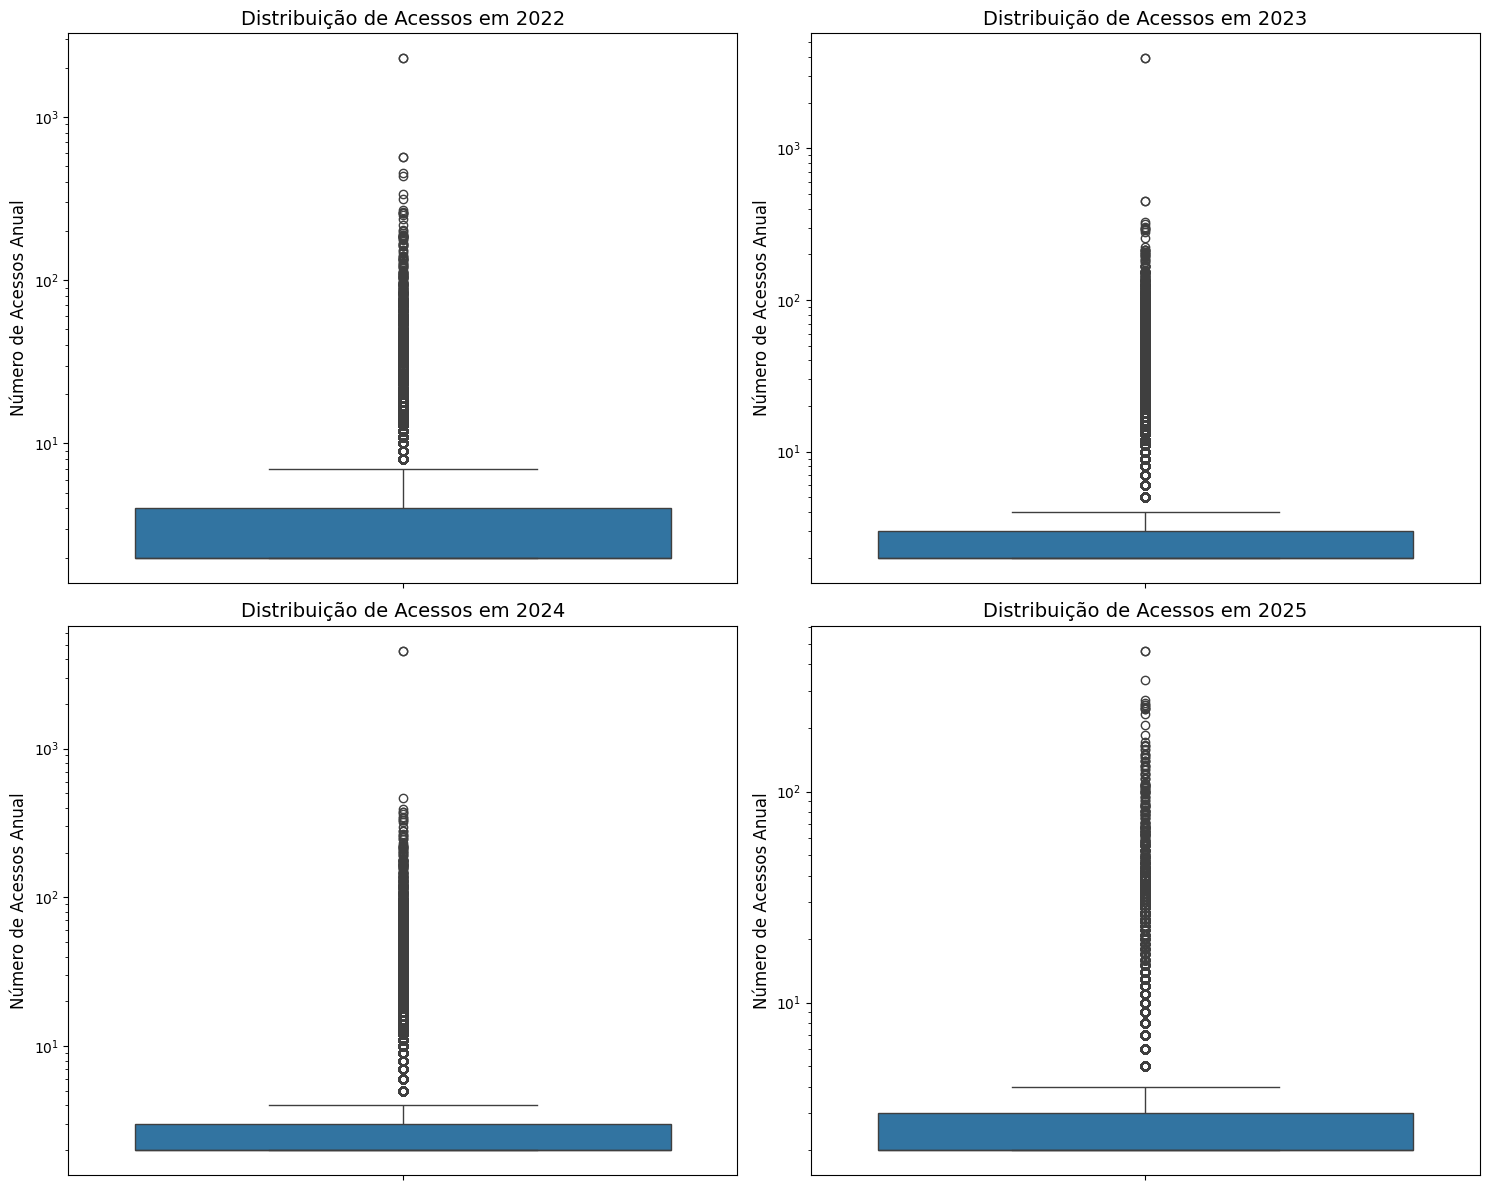

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Documentação:
# O objetivo desta célula é visualizar a distribuição do 'numero_acessos' para cada ano,
# focando nos usuários com mais de 1 acesso, para identificar outliers visualmente.

print("--- Gerando Box Plots Anuais para Análise de Outliers ---")

# Criamos uma figura com 4 subplots (2 linhas, 2 colunas)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# Usamos .flatten() para facilitar a iteração sobre os eixos (axes)
axes = axes.flatten()

# Pegamos a lista de anos para garantir a ordem
anos = sorted(perfis_anuais_enriquecidos.keys())

# Iteramos sobre os anos e os eixos do gráfico ao mesmo tempo
for i, ano in enumerate(anos):
    df_ano = perfis_anuais_enriquecidos[ano]
    ax = axes[i] # Seleciona o subplot atual

    # Filtramos para incluir apenas usuários com mais de 1 acesso
    df_filtrado = df_ano[df_ano['numero_acessos'] > 1]
    
    # Criamos o Box Plot para o ano atual
    sns.boxplot(y='numero_acessos', data=df_filtrado, ax=ax)
    
    ax.set_title(f'Distribuição de Acessos em {ano}', fontsize=14)
    ax.set_ylabel('Número de Acessos Anual', fontsize=12)
    # Colocamos o eixo Y em escala logarítmica para melhor visualização dos outliers
    ax.set_yscale('log')

# Ajusta o layout para evitar sobreposição de títulos
plt.tight_layout()
plt.show()

### DFs Anuais

### Pré-processamento


--- Iniciando Análise para o Ano de 2022 ---
Base para o ano 2022 filtrada. Total de usuários = 217643. Total de usuários para análise: 47664. Número de features utilizado para a análise: 38


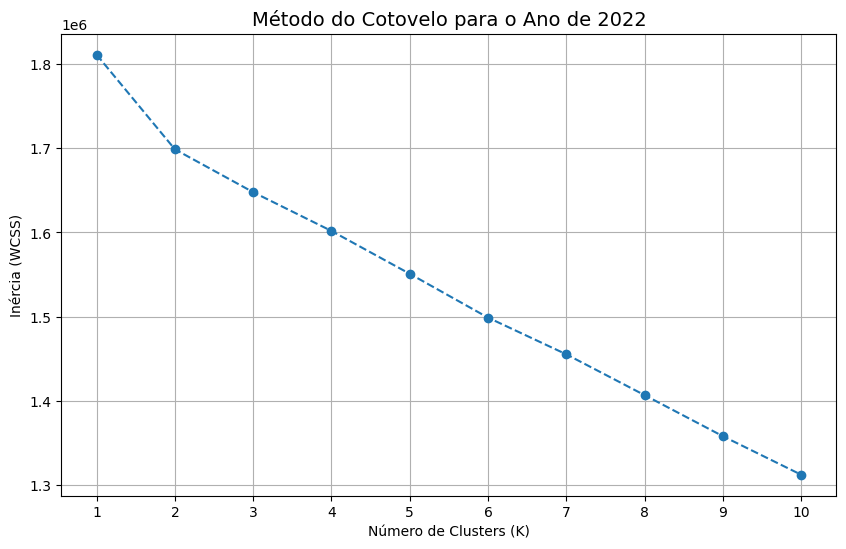


--- Iniciando Análise para o Ano de 2023 ---
Base para o ano 2023 filtrada. Total de usuários = 440631. Total de usuários para análise: 116781. Número de features utilizado para a análise: 38


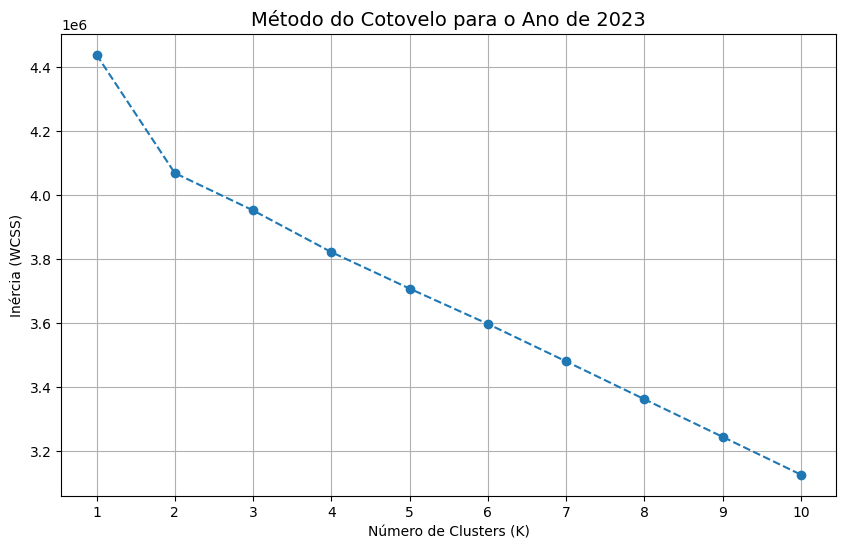


--- Iniciando Análise para o Ano de 2024 ---
Base para o ano 2024 filtrada. Total de usuários = 539543. Total de usuários para análise: 135252. Número de features utilizado para a análise: 38


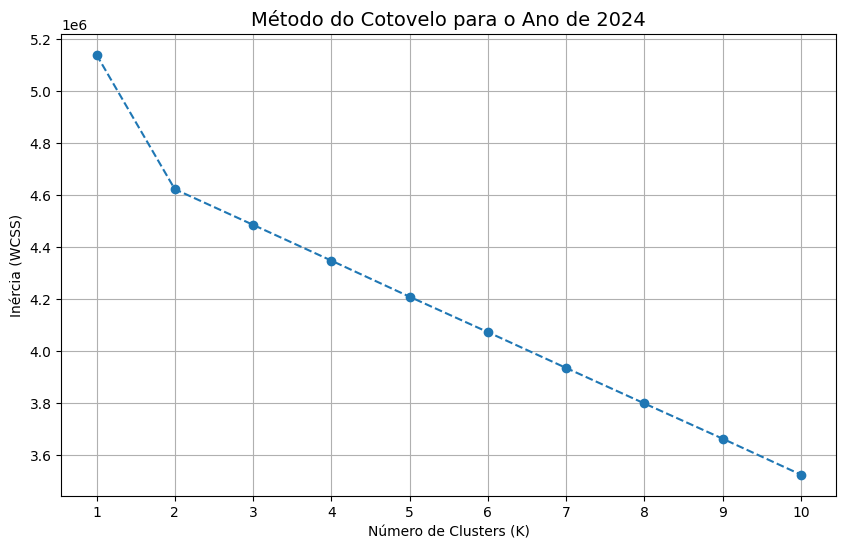


--- Iniciando Análise para o Ano de 2025 ---
Base para o ano 2025 filtrada. Total de usuários = 181746. Total de usuários para análise: 37338. Número de features utilizado para a análise: 37


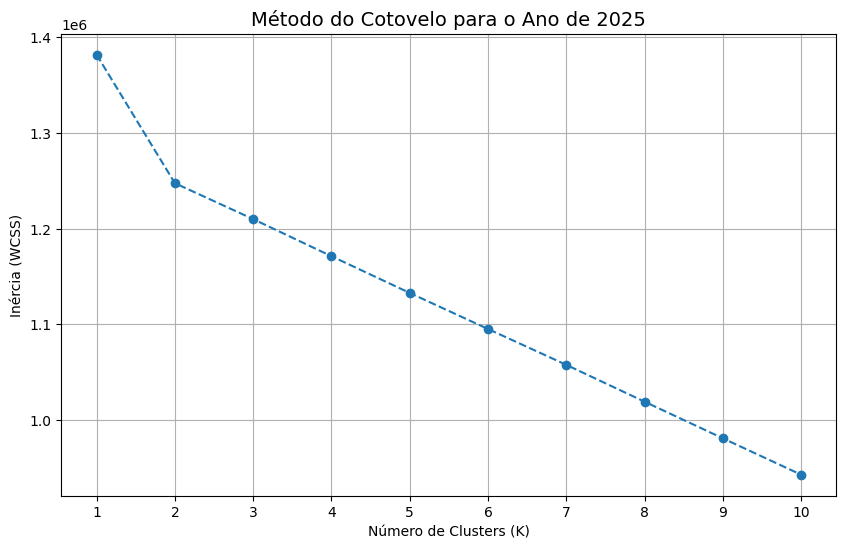

In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Documentação:
# Iteramos sobre cada ano para executar uma análise de cotovelo independente,
# agora com um log detalhado do processo de filtragem para cada período.

for ano, df_analise in perfis_anuais_enriquecidos.items():
    print(f"\n--- Iniciando Análise para o Ano de {ano} ---")
    
    # --- 1. FILTRAGEM DE USUÁRIOS (para o ano atual) ---
    df_analise.reset_index(inplace=True)
    
    # Captura o número de usuários ANTES do filtro
    total_inicial_ano = len(df_analise)
    
    # Filtro 1: Remove usuários com 1 ou menos acessos
    df_filtrado = df_analise[df_analise['numero_acessos'] > 1].copy()

    # Filtro 2: Remove o outlier mais extremo do ano
    if not df_filtrado.empty:
        max_acessos = df_filtrado['numero_acessos'].max()
        df_filtrado_final = df_filtrado[df_filtrado['numero_acessos'] < max_acessos].copy()
        # Captura o número de usuários DEPOIS do filtro
        total_final_ano = len(df_filtrado_final)
    else:
        print(f"Não há usuários com mais de 1 acesso para o ano {ano}.")
        continue

    # --- 2. PRÉ-PROCESSAMENTO FINAL (para o ano atual) ---
    features_numericas = [
        'numero_acessos', 'tempo_medio_sessao', 'total_alunos'
    ] + [col for col in df_filtrado_final.columns if col.startswith('pct_evento_')]
    features_categoricas = ['estado', 'currentstage']
    features_selecionadas = features_numericas + features_categoricas
    
    df_processado = df_filtrado_final[features_selecionadas].copy()
    df_processado['total_alunos'].fillna(df_processado['total_alunos'].median(), inplace=True)
    for col in features_categoricas:
        df_processado[col].fillna('Desconhecido', inplace=True)
    
    df_processado_encoded = pd.get_dummies(df_processado, columns=features_categoricas, dummy_na=False)
    
    # Captura o número de features utilizadas
    numero_features = len(df_processado_encoded.columns)
    
    # --- LOG PERSONALIZADO (COMO SOLICITADO) ---
    print(
        f"Base para o ano {ano} filtrada. "
        f"Total de usuários = {total_inicial_ano}. "
        f"Total de usuários para análise: {total_final_ano}. "
        f"Número de features utilizado para a análise: {numero_features}"
    )

    # --- 3. ESCALONAMENTO (para o ano atual) ---
    scaler = StandardScaler()
    df_final_modelo = pd.DataFrame(scaler.fit_transform(df_processado_encoded), columns=df_processado_encoded.columns)

    # --- 4. GRÁFICO DE COTOVELO (para o ano atual) ---
    wcss = []
    range_clusters = range(1, 11)
    for i in range_clusters:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
        kmeans.fit(df_final_modelo)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range_clusters, wcss, marker='o', linestyle='--')
    plt.title(f'Método do Cotovelo para o Ano de {ano}', fontsize=14)
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inércia (WCSS)')
    plt.xticks(range_clusters)
    plt.grid(True)
    plt.show()

--- Iniciando a Agregação de Perfis Anuais (Versão Completa) ---

--- Perfis anuais com proporções calculados e enriquecidos com sucesso! ---

--- Iniciando Pipeline Final com Re-rotulação de Clusters ---

--- Processando o Ano de 2022 ---

--- Processando o Ano de 2023 ---

--- Processando o Ano de 2024 ---

--- Processando o Ano de 2025 ---

--- Pipeline de Modelagem Finalizado com Sucesso! ---


--- Visualizações para o Ano de 2022 ---


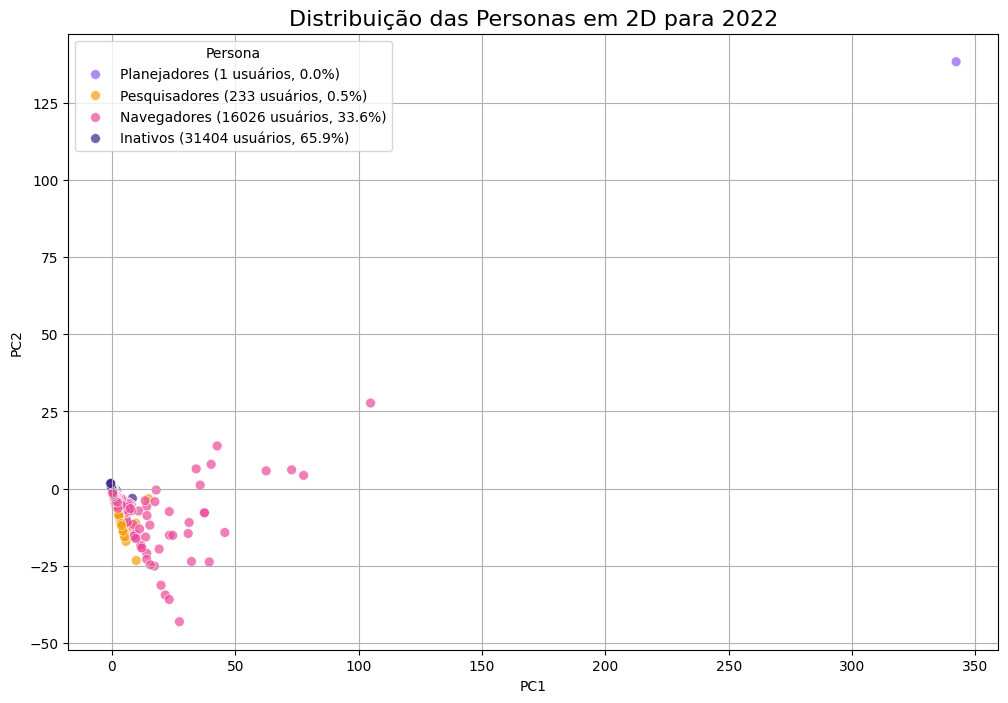

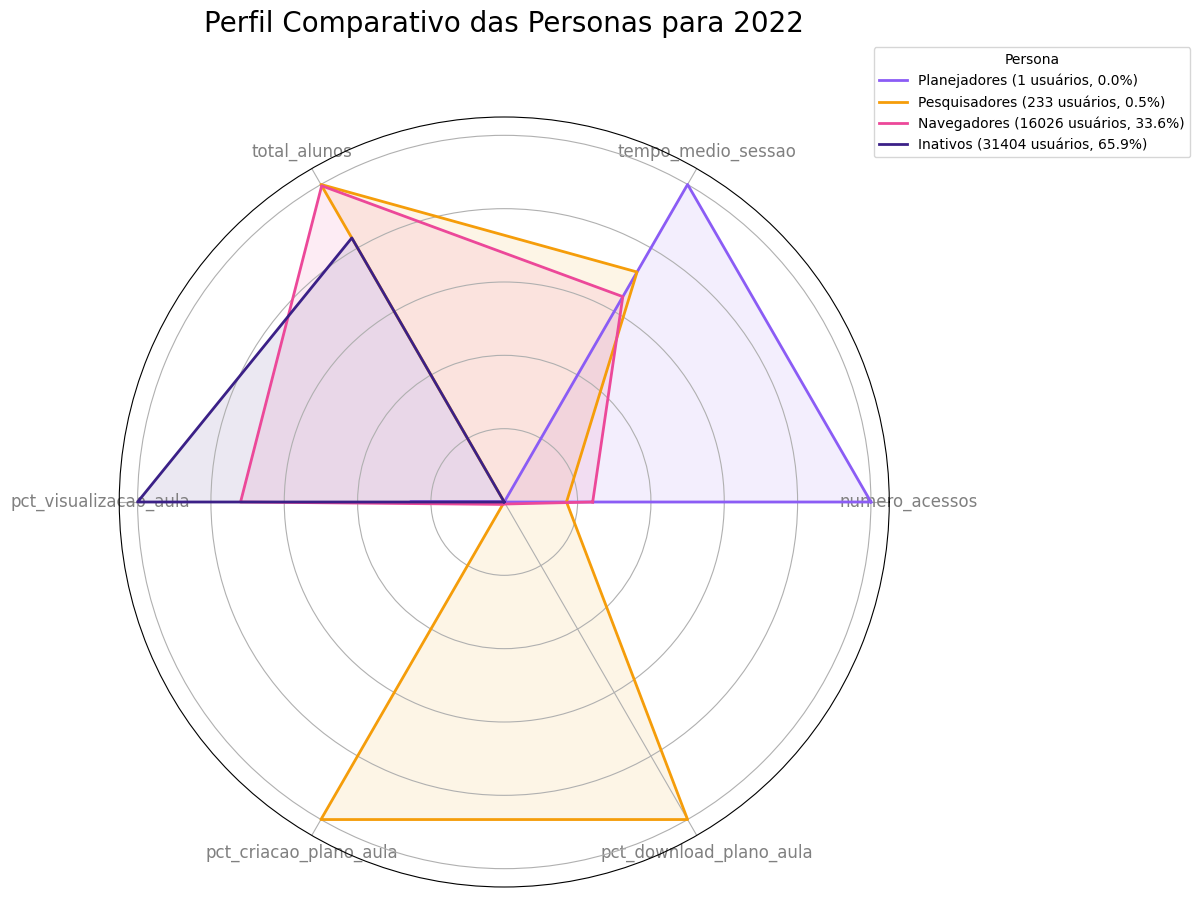



--- Visualizações para o Ano de 2023 ---


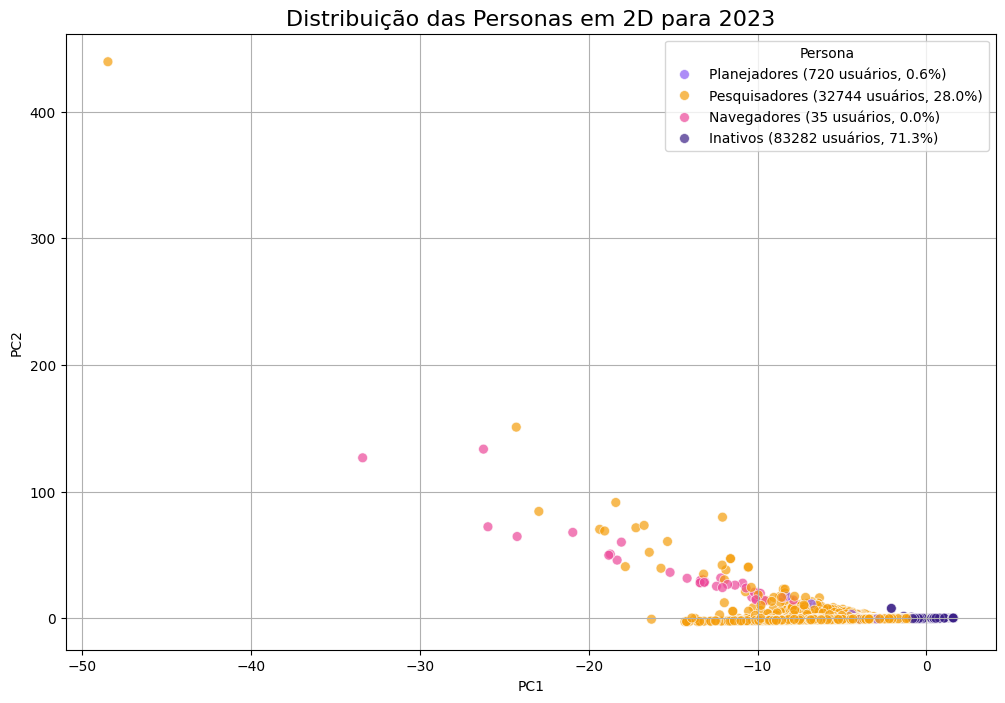

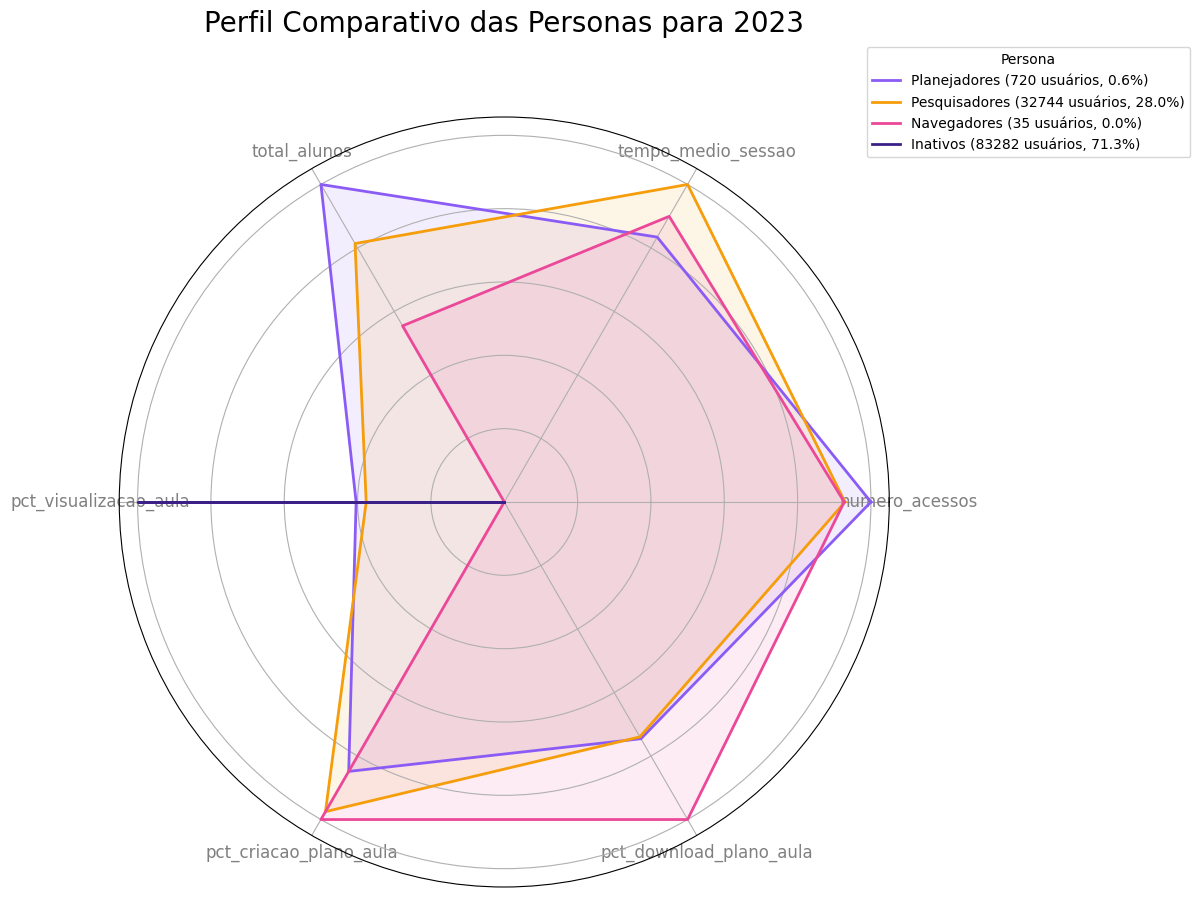



--- Visualizações para o Ano de 2024 ---


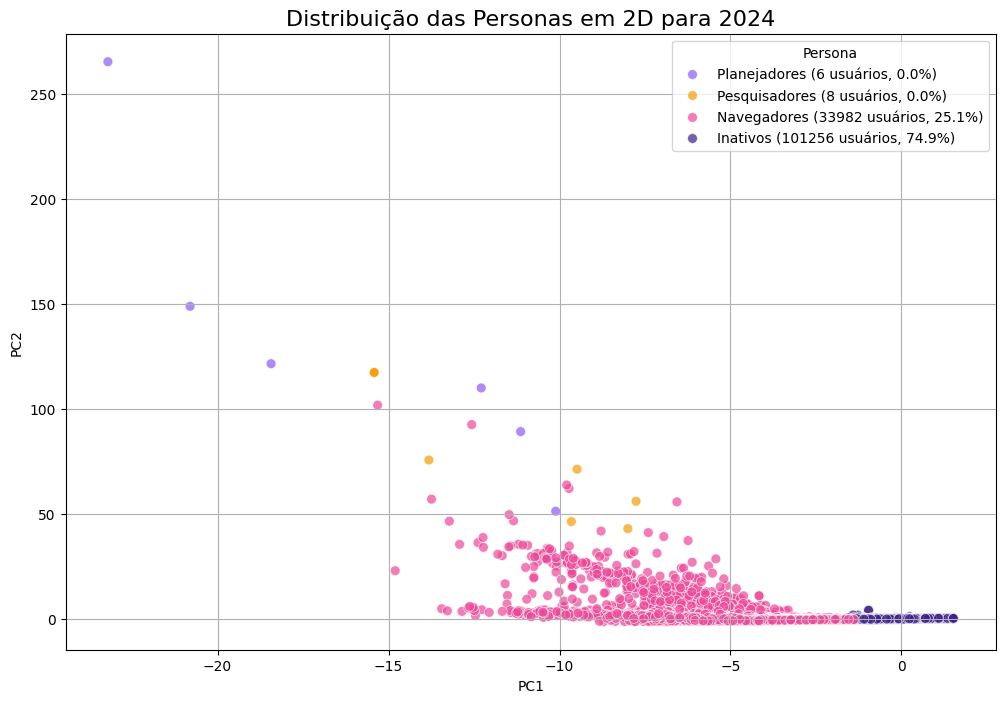

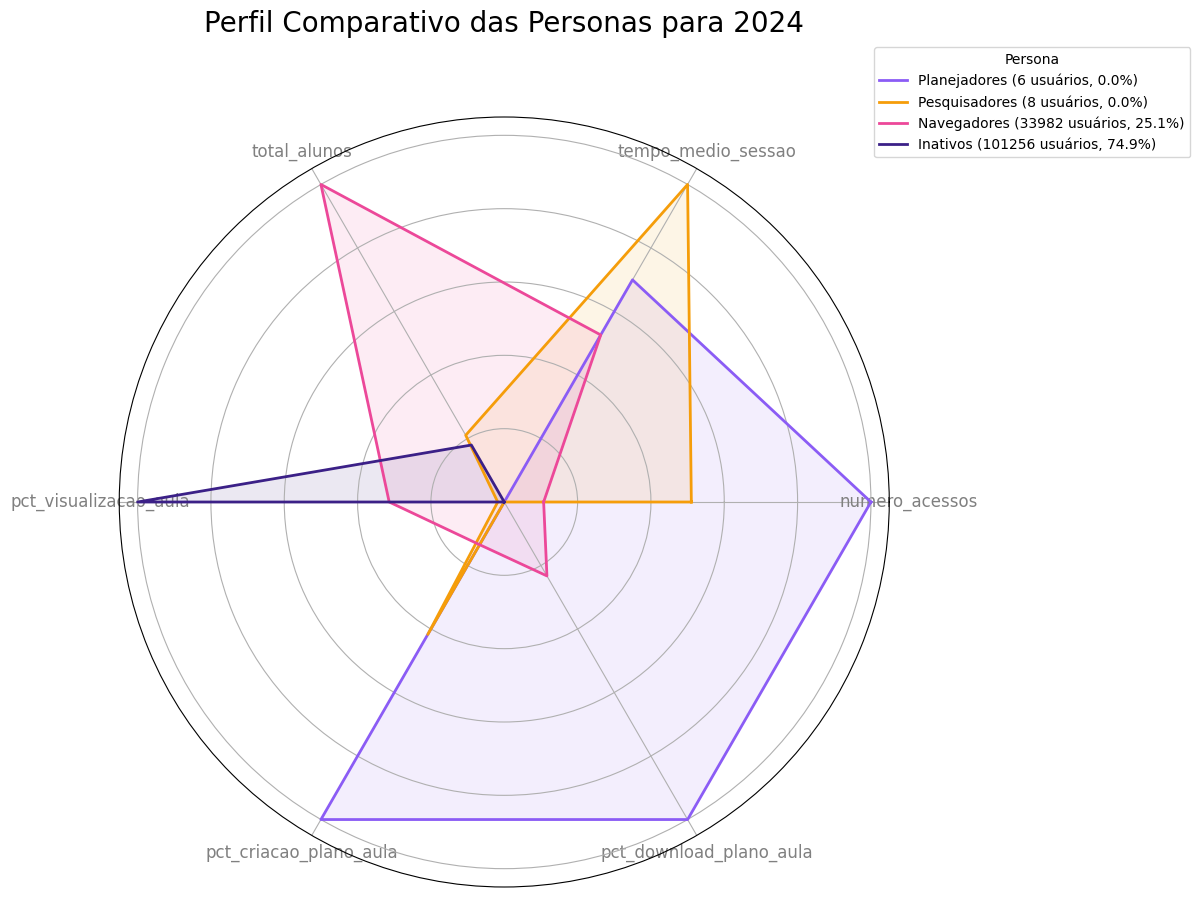



--- Visualizações para o Ano de 2025 ---


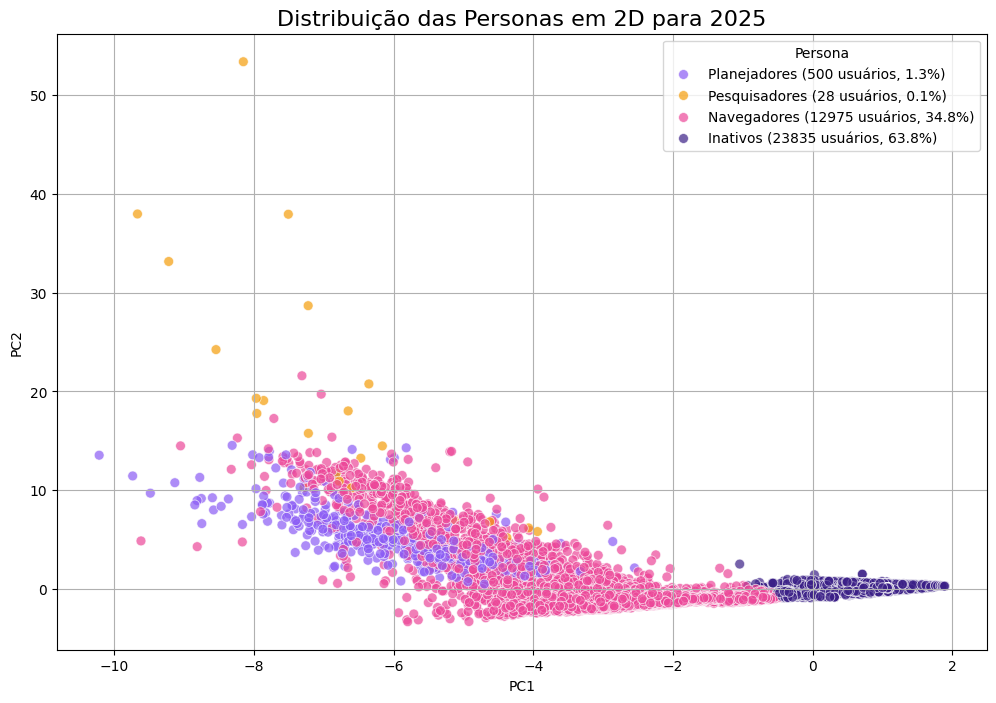

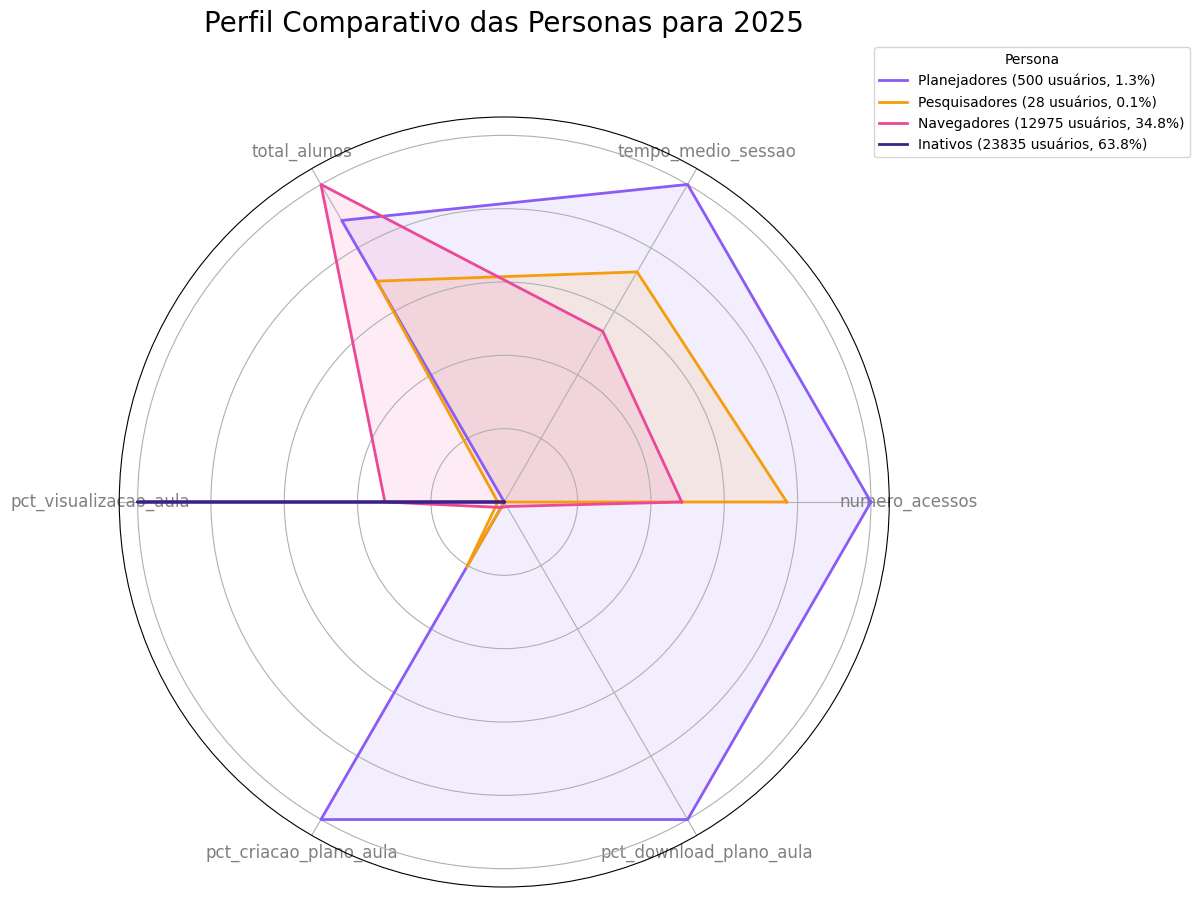

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### =======================================================================
### PARTE 1: AGREGAÇÃO CORRETA E ENRIQUECIMENTO DOS DADOS
### =======================================================================

print("--- Iniciando a Agregação de Perfis Anuais (Versão Completa) ---")

# Dicionário para armazenar os dataframes de perfis anuais
perfis_anuais = {}

# Pivotações feitas uma vez fora do loop para eficiência
agg_event_type = fct_interaction.groupby(['unique_id', 'event_type']).size().unstack(fill_value=0)

# Iteramos sobre cada ano para criar um perfil detalhado
for ano, df_ano in df_unificado_final.groupby('ano'):
    
    # 1. Métricas de sessão
    df_agg_base = df_ano.groupby('unique_id').agg(
        numero_acessos=('unique_id', 'count'),
        tempo_total_sessao=('tempo_sessao', 'sum'),
        tempo_medio_sessao=('tempo_sessao', 'mean')
    )
    
    # 2. Proporção de uso por tipo de evento (aqui são criadas as colunas 'pct_*')
    eventos_totais_ano = agg_event_type[agg_event_type.index.isin(df_agg_base.index)]
    total_eventos_por_usuario = eventos_totais_ano.sum(axis=1)
    eventos_pct = eventos_totais_ano.div(total_eventos_por_usuario, axis=0).replace(np.nan, 0).add_prefix('pct_')

    # Unificação final do perfil anual
    df_perfil_ano = df_agg_base.join(eventos_pct, how='left')
    df_perfil_ano.fillna(0, inplace=True)
    perfis_anuais[ano] = df_perfil_ano.reset_index()

# Enriquecimento com dados demográficos
perfis_anuais_enriquecidos = {}
colunas_para_adicionar = ['unique_id', 'estado', 'data_entrada', 'total_alunos', 'currentstage', 'currentsubject']
for ano, df_perfil in perfis_anuais.items():
    df_enriquecido = pd.merge(df_perfil, dim_teachers[colunas_para_adicionar], on='unique_id', how='left')
    perfis_anuais_enriquecidos[ano] = df_enriquecido

print("\n--- Perfis anuais com proporções calculados e enriquecidos com sucesso! ---")


### =======================================================================
### PARTE 2: PIPELINE DE MODELAGEM E RE-ROTULAÇÃO
### =======================================================================

PERSONA_ORDER = ["Planejadores", "Pesquisadores", "Navegadores", "Inativos"]
N_CLUSTERS = 4
resultados_finais_anuais = {}

print("\n--- Iniciando Pipeline Final com Re-rotulação de Clusters ---")

for ano, df_analise in perfis_anuais_enriquecidos.items():
    print(f"\n--- Processando o Ano de {ano} ---")
    
    # 1. Filtragem de Usuários
    df_filtrado = df_analise[df_analise['numero_acessos'] > 1].copy()
    if not df_filtrado.empty:
        max_acessos = df_filtrado['numero_acessos'].max()
        df_filtrado_final = df_filtrado[df_filtrado['numero_acessos'] < max_acessos].copy()
    else: continue

    # 2. Pré-processamento
    features_numericas = ['numero_acessos', 'tempo_medio_sessao', 'total_alunos'] + [col for col in df_filtrado_final.columns if col.startswith('pct_')]
    features_categoricas = ['estado', 'currentstage']
    df_processado = df_filtrado_final[['unique_id'] + features_numericas + features_categoricas].copy()
    df_processado['total_alunos'].fillna(df_processado['total_alunos'].median(), inplace=True)
    for col in features_categoricas: df_processado[col].fillna('Desconhecido', inplace=True)
    df_processado_encoded = pd.get_dummies(df_processado.drop(columns=['unique_id']), columns=features_categoricas)

    # 3. Escalonamento e Modelagem K-Means
    scaler = StandardScaler()
    df_final_modelo = pd.DataFrame(scaler.fit_transform(df_processado_encoded), columns=df_processado_encoded.columns)
    kmeans = KMeans(n_clusters=N_CLUSTERS, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(df_final_modelo)
    
    # 4. Mapeamento e Re-rotulação dos Clusters
    df_processado['temp_cluster'] = kmeans.labels_
    analise_temp = df_processado.groupby('temp_cluster')[features_numericas].mean(numeric_only=True)
    mapa_para_persona = {}
    df_restante = analise_temp.copy()
    if len(df_restante) > 0:
        id_planejadores = df_restante['numero_acessos'].idxmax()
        mapa_para_persona[id_planejadores] = "Planejadores"
        df_restante = df_restante.drop(id_planejadores)
    if len(df_restante) > 0:
        id_pesquisadores = df_restante['tempo_medio_sessao'].idxmax()
        mapa_para_persona[id_pesquisadores] = "Pesquisadores"
        df_restante = df_restante.drop(id_pesquisadores)
    if len(df_restante) > 0:
        id_navegadores = df_restante['numero_acessos'].idxmax()
        mapa_para_persona[id_navegadores] = "Navegadores"
        df_restante = df_restante.drop(id_navegadores)
    if len(df_restante) > 0:
        id_inativos = df_restante.index[0]
        mapa_para_persona[id_inativos] = "Inativos"
    mapa_persona_para_num_final = {persona: i for i, persona in enumerate(PERSONA_ORDER)}
    df_processado['persona'] = df_processado['temp_cluster'].map(mapa_para_persona)
    df_processado['cluster'] = df_processado['persona'].map(mapa_persona_para_num_final)

    # 5. PCA para Visualização e Consolidação
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_final_modelo)
    df_processado['PC1'] = principal_components[:, 0]
    df_processado['PC2'] = principal_components[:, 1]
    resultados_finais_anuais[ano] = df_processado.drop(columns=['temp_cluster'])

print("\n--- Pipeline de Modelagem Finalizado com Sucesso! ---")


### =======================================================================
### PARTE 3: VISUALIZAÇÃO FINAL E CONSISTENTE (VERSÃO CORRIGIDA)
### =======================================================================

PALETTE_PERSONAS = {"Planejadores": '#8b5cf5', "Pesquisadores": '#f59d0a', "Navegadores": '#ec4899', "Inativos": '#3b2087'}
PERSONA_ORDER = ["Planejadores", "Pesquisadores", "Navegadores", "Inativos"]

for ano, df_resultado in resultados_finais_anuais.items():
    print(f"\n\n--- Visualizações para o Ano de {ano} ---")
    
    # --- Preparação da Legenda Dinâmica ---
    total_usuarios_ano = len(df_resultado)
    persona_counts = df_resultado['persona'].value_counts()
    
    # Criamos um dicionário com os rótulos completos para a legenda
    legend_labels = {
        # --- CORREÇÃO AQUI ---
        # Removido o ", 0" extra do segundo .get()
        persona: f"{persona} ({persona_counts.get(persona, 0)} usuários, {persona_counts.get(persona, 0)/total_usuarios_ano:.1%})"
        for persona in PERSONA_ORDER
    }

    # --- Gráfico 1: Scatter Plot dos Clusters ---
    plt.figure(figsize=(12, 8))
    ax_scatter = sns.scatterplot(x='PC1', y='PC2', hue='persona', data=df_resultado, palette=PALETTE_PERSONAS, hue_order=PERSONA_ORDER, alpha=0.7, s=50)
    
    # Atualizamos a legenda do scatter plot
    handles, labels = ax_scatter.get_legend_handles_labels()
    new_labels = [legend_labels.get(label, label) for label in labels]
    ax_scatter.legend(handles, new_labels, title='Persona')
    
    plt.title(f'Distribuição das Personas em 2D para {ano}', fontsize=16)
    plt.grid(True)
    plt.show()
        
    # --- Gráfico 2: Gráfico de Radar ---
    analise_final = df_resultado.groupby('persona').mean(numeric_only=True)
    features_radar = ['numero_acessos', 'tempo_medio_sessao', 'total_alunos', 'pct_visualizacao_aula', 'pct_criacao_plano_aula', 'pct_download_plano_aula']
    features_radar_existentes = [col for col in features_radar if col in analise_final.columns]
    
    if not features_radar_existentes:
        print(f"Skipping Radar chart for {ano} due to missing features.")
        continue
        
    df_radar = analise_final[features_radar_existentes]
    
    scaler_radar = MinMaxScaler()
    df_radar_scaled = pd.DataFrame(scaler_radar.fit_transform(df_radar), columns=features_radar_existentes, index=df_radar.index)
    
    labels = df_radar_scaled.columns
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for persona in PERSONA_ORDER:
        if persona in df_radar_scaled.index:
            values = df_radar_scaled.loc[persona].tolist()
            values += values[:1]
            cor = PALETTE_PERSONAS[persona]
            ax.plot(angles, values, color=cor, linewidth=2, linestyle='solid', label=legend_labels[persona])
            ax.fill(angles, values, color=cor, alpha=0.1)

    plt.xticks(angles[:-1], labels, color='grey', size=12)
    ax.set_yticklabels([])
    plt.title(f'Perfil Comparativo das Personas para {ano}', size=20, y=1.1)
    plt.legend(title="Persona", loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.show()